In [1]:
import copy
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
class MiniBatchPDCDP:
    def __init__(self, Parts: int, Batchsize: int, lmbda: float) -> None:
        self.Parts = Parts
        self.batchsize = Batchsize
        self.lmbda = lmbda
        self.maxiter = 100
    
    def fit(self, X):
        self.num_clusters = 1
        self.labels = np.zeros(len(X))
        self.centroids = X[np.random.choice(X.shape[0], self.num_clusters, replace=False)]
        for _ in range(self.maxiter):
            batch = X[np.random.choice(X.shape[0],
                                        self.batchsize, replace=False)]
            splitted_batch = np.array_split(batch, self.Parts) #shape of splitted_batch is p by (num_items_in_part_p by d)
            num_items_in_part_p = [len(x_p) for x_p in splitted_batch] # shape is 1 by p
            pool = multiprocessing.Pool()
            processes = [pool.apply_async(self.squared_l2, 
                                        args=(splitted_batch[i], )) 
                                        for i in range(self.Parts)]
            S_p = [p.get() for p in processes] # p by (num_items_in_part_p by 1)
            i_max = np.ones(self.Parts)*-1
            d_max = np.ones(self.Parts)*-1
            pool = multiprocessing.Pool()
            processes = [pool.apply_async(self.do_in_parallel, 
                                        args=(splitted_batch[i],
                                              num_items_in_part_p[i], 
                                              S_p[i],
                                              i_max[i],
                                              d_max[i],)) 
                                        for i in range(self.Parts)]
            result = [p.get() for p in processes]
            i_max = [result[i][0] for i in range(self.Parts)]
            d_max = [result[i][1] for i in range(self.Parts)]
            splitted_labels = [result[i][2] for i in range(self.Parts)]
            p_max = np.argmax(d_max)
            if d_max[p_max] > self.lmbda:
                self.num_clusters += 1
                self.centroids = np.vstack((self.centroids, splitted_batch[p_max][int(i_max[p_max])]))
                splitted_labels[p_max][int(i_max[p_max])] = self.num_clusters - 1
            self.labels = np.concatenate(splitted_labels)
            self.total_num_in_each_cluster = np.unique(self.labels, return_counts= True)[1]
            pool = multiprocessing.Pool()
            processes = [pool.apply_async(self.move_to_Xi, args=(batch, i,)) 
                                    for i in range(self.num_clusters)]
            result = [p.get() for p in processes]
            this_iter_centers = np.concatenate(result).reshape(-1, 2)
            if np.all(this_iter_centers == self.centroids):
                break
            else:
                self.centroids = np.concatenate(result).reshape(-1, 2)

    def squared_l2(self, batch):
        return (batch**2).sum(axis=1)
    
    def do_in_parallel(self, batch , num_items_in_part_p, S_p, i_max, d_max):
        s_bar = ((self.centroids)**2).sum(axis=1)
        Np_copies = np.array(list(s_bar)*len(batch)).reshape(len(batch),len(s_bar))
        D_p = -2*batch.dot(self.centroids.T) + Np_copies # Np by K
        splitted_labels = np.argmin(D_p, axis=1)
        for j in range(num_items_in_part_p):
            k = int(splitted_labels[j])
            if np.sqrt(D_p[j, k] + S_p[j]) > d_max:
                d_max = np.sqrt(D_p[j, k] + S_p[j])
                i_max = j
        return i_max, d_max, splitted_labels
    
    def move_to_Xi(self, batch, k):
        copy_centroid = copy.deepcopy(self.centroids[k])
        X_in_cluster_k = batch[self.labels == k]
        Nk = copy.deepcopy(self.total_num_in_each_cluster[k])
        for x in X_in_cluster_k:
            Nk += 1
            copy_centroid = ((1 - (1/Nk))*copy_centroid) + (x/Nk)
        return copy_centroid

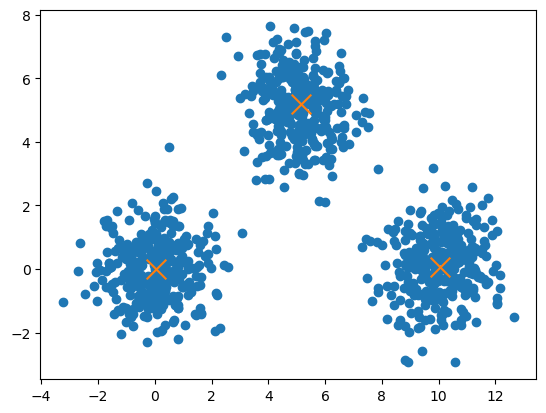

In [3]:
# Example usage
if __name__ =="__main__":
    np.random.seed(42)
    N = 1000
    K = 3
    means = np.array([[0, 0], [5, 5], [10, 0]])
    cov = np.eye(2)
    # this is a K by N array of random multivariate normal distributions
    X = np.vstack([np.random.multivariate_normal(mean, cov, int(N / K)) for mean in means])

    mini = MiniBatchPDCDP(4, 100, 7)
    mini.fit(X)
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(mini.centroids[:,0], mini.centroids[:,1], marker='x', s=200)
    plt.show()